In [91]:
import glob
import os
import webdataset as wds
from tqdm import tqdm
import torch
from functools import partial
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

sns.set_style("darkgrid")
sns.set_context("paper")


TASK = 'histone_modification'
DATA_DIR = f'../../data/'
BATCH_SIZE = 256
SHARD_SIZE = 50000
BUFFER_SIZE = 200
N_WORKERS = 32
annotations_path = f'{DATA_DIR}/{TASK}/{TASK}.bed'

def get_tars(tar_dir):
    tars = glob.glob(os.path.join(tar_dir, "*.tar.gz"))
    print(f'Tars: {tars}')
    return tars

def create_shards(sample_idxs, shard_size, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    shards = [sample_idxs[i:i + shard_size] for i in range(0, len(sample_idxs), shard_size)]
    print(f'Shards: {shards}')

    for idx, shard in tqdm(enumerate(shards)):
        output_path = os.path.join(output_dir, f'{idx}.tar.gz')
        if os.path.exists(output_path):
            continue

        sink = wds.TarWriter(output_path, compress=True)
        for key_idx, sample_id in enumerate(shard):
            sink.write({'__key__': f"sample_{key_idx + SHARD_SIZE}", 'shard_idx.npy': np.array(idx, dtype=np.int32), 'sample_idx.npy': np.array(sample_id, dtype=np.int32)})
        sink.close()

    return get_tars(output_dir)

def iterate_webdataset(tars, shardshuffle=True, buffer_size=None,n_workers=1):
    sample_ids = []
    shard_ids = []

    n_workers = min(len(tars), n_workers)

    if shardshuffle:
        shardshuffle = len(tars)

    dataset = wds.WebDataset(tars, shardshuffle=shardshuffle)
    if buffer_size is not None:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.decode()
    dataset = dataset.to_tuple('shard_idx.npy', 'sample_idx.npy')
    dataset = dataset.map_tuple(torch.from_numpy, torch.from_numpy)

    dataloader = wds.WebLoader(dataset, num_workers=n_workers, batch_size=None)

    for idx, (shard_id, sample_id) in tqdm(enumerate(dataloader)):
        shard_ids.append(shard_id.item())
        sample_ids.append(sample_id.item())

    return np.array(sample_ids), np.array(shard_ids)

def calculate_spearman(x, y):
    correlation, p_value = spearmanr(x, y, axis=0)
    return correlation, p_value


<Axes: xlabel='label'>

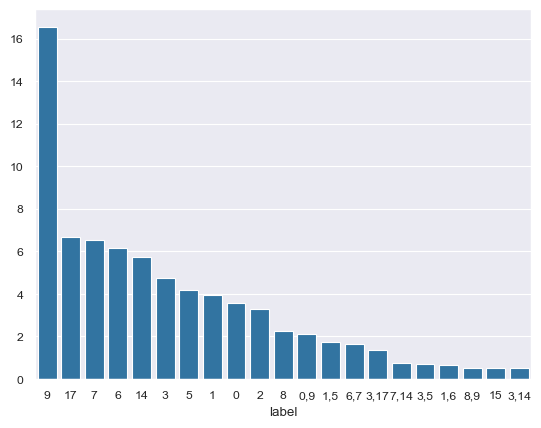

In [2]:
df = pd.read_csv(annotations_path, sep='\t', low_memory=False)
label_distribution = (df['label'].value_counts() / df['label'].value_counts().sum()*100).sort_values(ascending=False)
label_distribution = label_distribution[label_distribution > 0.5]
sns.barplot(x=label_distribution.index, y=label_distribution.values)

In [3]:
df = pd.read_csv(annotations_path, sep="\t", low_memory=False)

df["chromosome"] = df["chromosome"].str.replace("chr", "")

chromosomes = [f"{idx}" for idx in range(1, 23)] + ["X", "Y"]
df["chromosome"] = pd.Categorical(
    df["chromosome"], categories=chromosomes, ordered=True
)

df = df[df['split'] == 'train'].reset_index(drop=True)
df

,chromosome,start,end,score,-,strand,label,split
0,13,18172516,18173028,.,1,+,7,train
1,13,18189858,18190370,.,1,+,6,train
2,13,18191521,18192033,.,1,+,6,train
3,13,18212875,18213387,.,1,+,"2,7",train
4,13,18213362,18213874,.,1,+,2,train
...,...,...,...,...,...,...,...,...
433856,17,83199009,83199521,.,1,+,5,train
433857,17,83199485,83199997,.,1,+,9,train
433858,17,83200265,83200777,.,1,+,"1,5",train
433859,17,83204011,83204523,.,1,+,2,train


<Axes: >

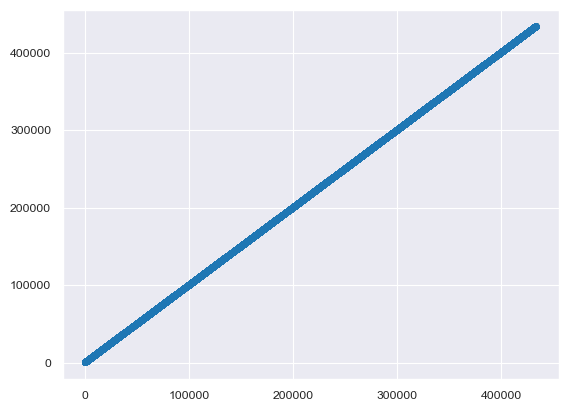

In [4]:
gt_idx = df.index.values
sns.scatterplot(x=gt_idx, y=gt_idx, edgecolor='none')

<Axes: >

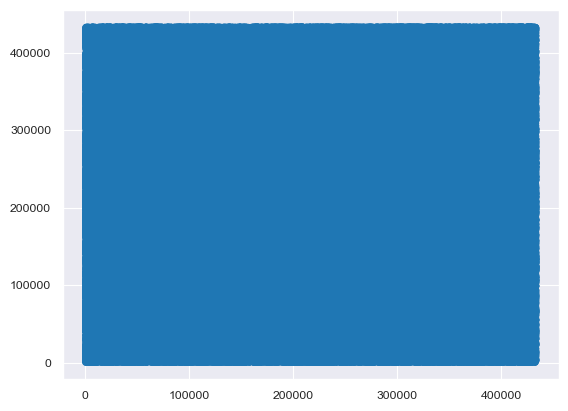

In [5]:
shuffled_idx = df.sample(frac=1, random_state=42).index.values
sns.scatterplot(x=gt_idx, y=shuffled_idx, edgecolor='none')

In [6]:
calculate_spearman(gt_idx, shuffled_idx)

-0.001067719861486943

## Default BEND parameters

In [7]:
def load_or_create_df(df_name, indexes, shard_size=SHARD_SIZE, buffer_size=BUFFER_SIZE, n_workers=N_WORKERS):
    output_dir= f'./{TASK}/shards_{SHARD_SIZE}/{df_name}/'
    df_path = f'{output_dir}/{df_name}.csv'

    if not os.path.exists(df_path):
        bend_tars = create_shards(indexes, shard_size, output_dir)
        bend_idx, bend_shard_idx = iterate_webdataset(bend_tars, shardshuffle=False, buffer_size=buffer_size, n_workers=n_workers)
        df_bend = pd.DataFrame(zip(bend_idx, bend_shard_idx), columns=['sample_idx', 'shard_idx'])
        df_bend.to_csv(df_path, index=False)
    else:
        df_bend = pd.read_csv(df_path)
    return df_bend

df_bend = load_or_create_df("bend_default", gt_idx)
df_bend


,sample_idx,shard_idx
0,100096,2
1,43,0
2,400025,8
3,200003,4
4,300057,6
...,...,...
433856,349991,6
433857,199974,3
433858,99876,1
433859,299868,5


In [8]:
calculate_spearman(gt_idx, df_bend['sample_idx'].values)

0.041797414246679515

In [9]:
calculate_spearman(gt_idx[:BATCH_SIZE], df_bend['sample_idx'].values[:BATCH_SIZE])

0.03721317807278553

<Axes: >

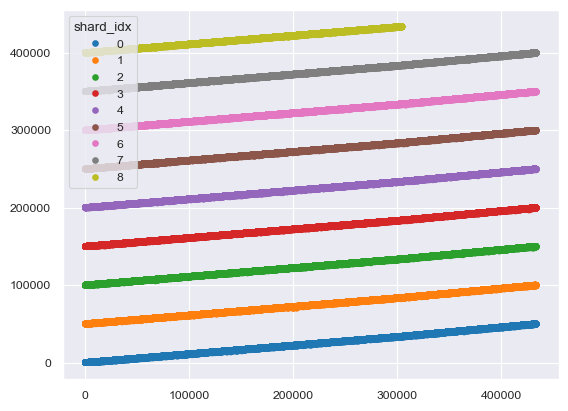

In [10]:
sns.scatterplot(x=gt_idx, y=df_bend['sample_idx'].values, edgecolor='none', hue=df_bend['shard_idx'], palette='tab10')

<Axes: >

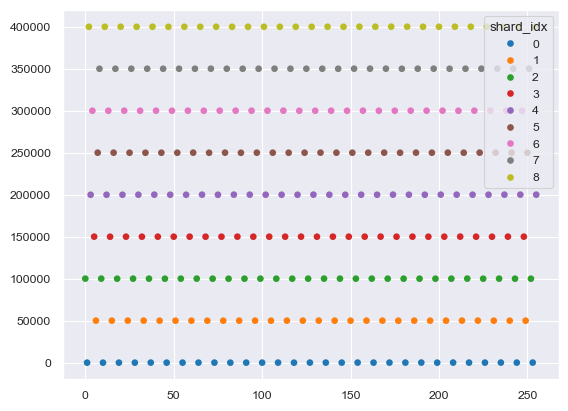

In [11]:
sns.scatterplot(x=gt_idx[:BATCH_SIZE], y=df_bend['sample_idx'].values[:BATCH_SIZE], edgecolor='none', hue=df_bend['shard_idx'][:BATCH_SIZE], palette='tab10')

<Axes: xlabel='sample_idx', ylabel='Count'>

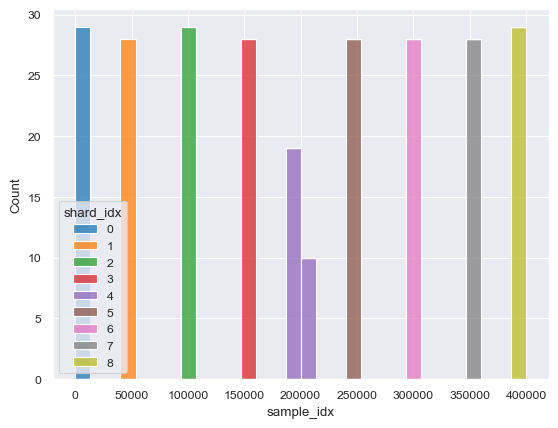

In [12]:
sns.histplot(data=df_bend[:BATCH_SIZE], x='sample_idx', hue='shard_idx', multiple='stack', bins=30, palette='tab10')


## Num Workers=1

In [13]:
df_bend_1 = load_or_create_df("bend_default_1", gt_idx, n_workers=1)
df_bend_1

,sample_idx,shard_idx
0,100076,2
1,100095,2
2,100029,2
3,100013,2
4,100015,2
...,...,...
433856,399899,7
433857,399891,7
433858,399808,7
433859,399174,7


<Axes: >

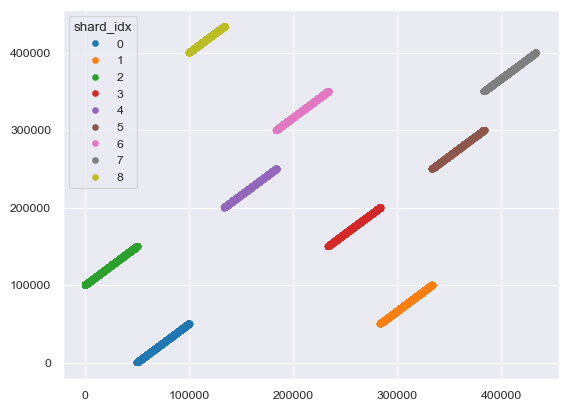

In [14]:
sns.scatterplot(x=gt_idx, y=df_bend_1['sample_idx'].values, edgecolor='none', hue=df_bend_1['shard_idx'], palette='tab10')

In [15]:
calculate_spearman(gt_idx, df_bend_1['sample_idx'].values)

0.4077891983129279

In [16]:
calculate_spearman(gt_idx[:BATCH_SIZE], df_bend_1['sample_idx'].values[:BATCH_SIZE])

0.5135063801785305

<Axes: >

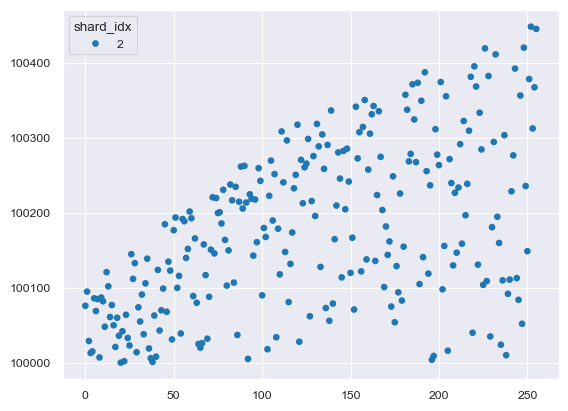

In [17]:
sns.scatterplot(x=gt_idx[:BATCH_SIZE], y=df_bend_1['sample_idx'].values[:BATCH_SIZE], edgecolor='none', hue=df_bend_1['shard_idx'][:BATCH_SIZE], palette='tab10')

<Axes: xlabel='sample_idx', ylabel='Count'>

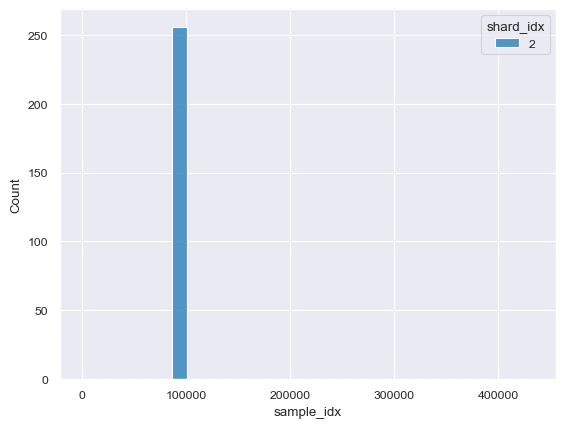

In [53]:
sns.histplot(data=df_bend_1[:BATCH_SIZE], x='sample_idx', hue='shard_idx', multiple='stack', bins=30, binrange=(0, len(df_bend_1)), palette='tab10')

## Pre-Shuffling annotations

In [19]:
df_shuffled = load_or_create_df('bend_shuffled', shuffled_idx)
df_shuffled

,sample_idx,shard_idx
0,360361,2
1,249954,0
2,15454,8
3,76081,4
4,266347,6
...,...,...
433856,47035,6
433857,277620,3
433858,292360,1
433859,356733,5


In [20]:
calculate_spearman(gt_idx, df_shuffled['sample_idx'].values)

0.00042457534891621705

In [21]:
calculate_spearman(shuffled_idx, df_shuffled['sample_idx'].values)

0.00035302334631756414

<Axes: >

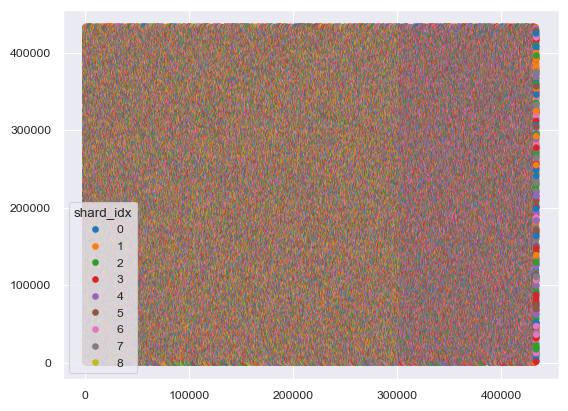

In [22]:
sns.scatterplot(x=gt_idx, y=df_shuffled['sample_idx'].values, edgecolor='none', hue=df_shuffled['shard_idx'], palette='tab10')

<Axes: >

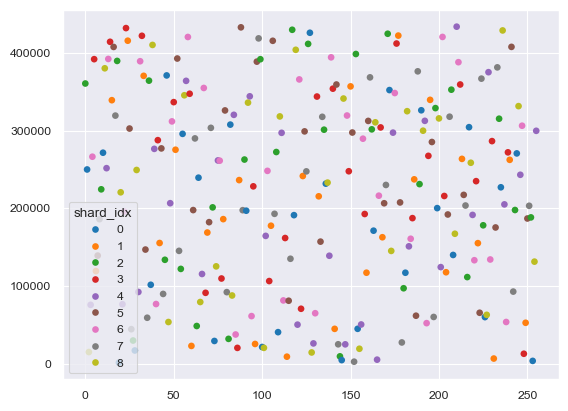

In [23]:
sns.scatterplot(x=gt_idx[:BATCH_SIZE], y=df_shuffled['sample_idx'].values[:BATCH_SIZE], edgecolor='none', hue=df_shuffled['shard_idx'][:BATCH_SIZE], palette='tab10')

<Axes: xlabel='sample_idx', ylabel='Count'>

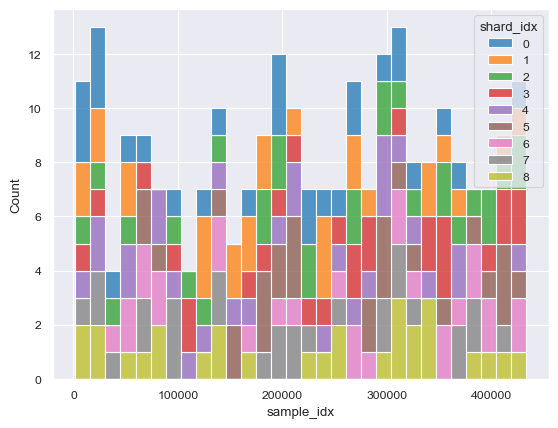

In [24]:
sns.histplot(data=df_shuffled[:BATCH_SIZE], x='sample_idx', hue='shard_idx', multiple='stack', bins=30, palette='tab10')


## Pre-shuffling, num workers = 1

In [25]:
df_shuffled_1 = load_or_create_df('bend_shuffled_1', shuffled_idx, n_workers=1)
df_shuffled_1

,sample_idx,shard_idx
0,315552,2
1,406028,2
2,325594,2
3,381216,2
4,159280,2
...,...,...
433856,342625,7
433857,135246,7
433858,51544,7
433859,386492,7


<Axes: >

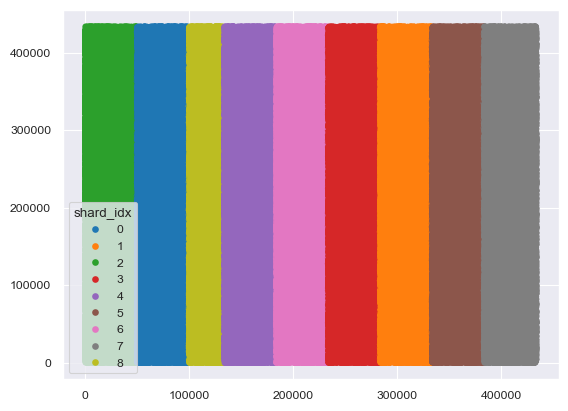

In [26]:
sns.scatterplot(x=gt_idx, y=df_shuffled_1['sample_idx'].values, edgecolor='none', hue=df_shuffled_1['shard_idx'], palette='tab10')

<Axes: >

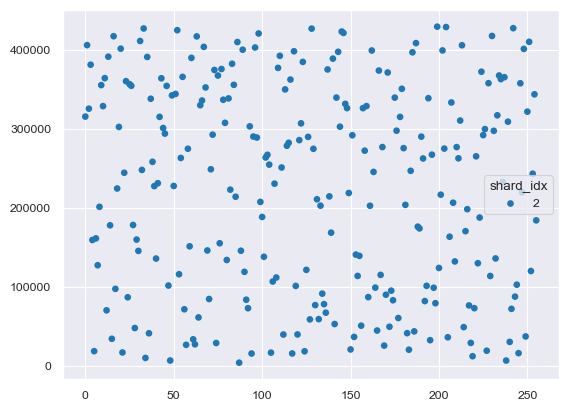

In [27]:
sns.scatterplot(x=gt_idx[:BATCH_SIZE], y=df_shuffled_1['sample_idx'].values[:BATCH_SIZE], edgecolor='none', hue=df_shuffled_1['shard_idx'][:BATCH_SIZE], palette='tab10')

<Axes: xlabel='sample_idx', ylabel='Count'>

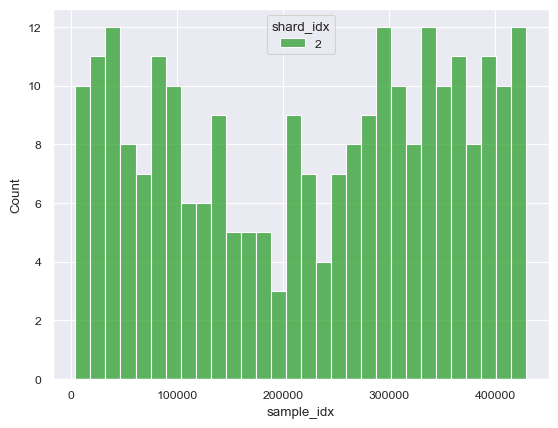

In [28]:
sns.histplot(data=df_shuffled_1[:BATCH_SIZE], x='sample_idx', hue='shard_idx', multiple='stack', bins=30, palette=[sns.color_palette("tab10")[2]])


## Bring all together

In [29]:
df_bend['n workers'] = N_WORKERS
df_bend_1['n workers'] = 1
df_shuffled['n workers'] = N_WORKERS
df_shuffled_1['n workers'] = 1

df_bend['pre-shuffle'] = False
df_bend_1['pre-shuffle'] = False
df_shuffled['pre-shuffle'] = True
df_shuffled_1['pre-shuffle'] = True

df_bend['access_order'] = gt_idx
df_bend_1['access_order'] = gt_idx
df_shuffled['access_order'] = gt_idx
df_shuffled_1['access_order'] = gt_idx

df_gt = pd.DataFrame({'sample_idx': gt_idx, 'shard_idx': pd.NA, 'n workers': pd.NA, 'pre-shuffle': False, 'access_order': gt_idx})
df_random = pd.DataFrame({'sample_idx': shuffled_idx, 'shard_idx': pd.NA, 'n workers': pd.NA, 'pre-shuffle': True, 'access_order': gt_idx})

df_gt['Name'] = 'No Shuffle'
df_bend['Name'] = 'BEND'
df_bend_1['Name'] = 'BEND 1 Worker'
df_shuffled['Name'] = 'BEND Pre-Shuffled'
df_shuffled_1['Name'] = 'BEND Pre-Shuffled 1 Worker'
df_random['Name'] = 'Shuffled'

df_all = pd.concat([df_gt, df_bend_1, df_bend, df_shuffled_1, df_shuffled, df_random], ignore_index=True)

/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_43545/755841696.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1, idx].legend().set_visible(False)
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_43545/755841696.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1, idx].legend().set_visible(False)
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_43545/755841696.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1, idx].legend().set_visible(False)
/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_43545/755841696.py:35: UserWarning: No artists with labels fou

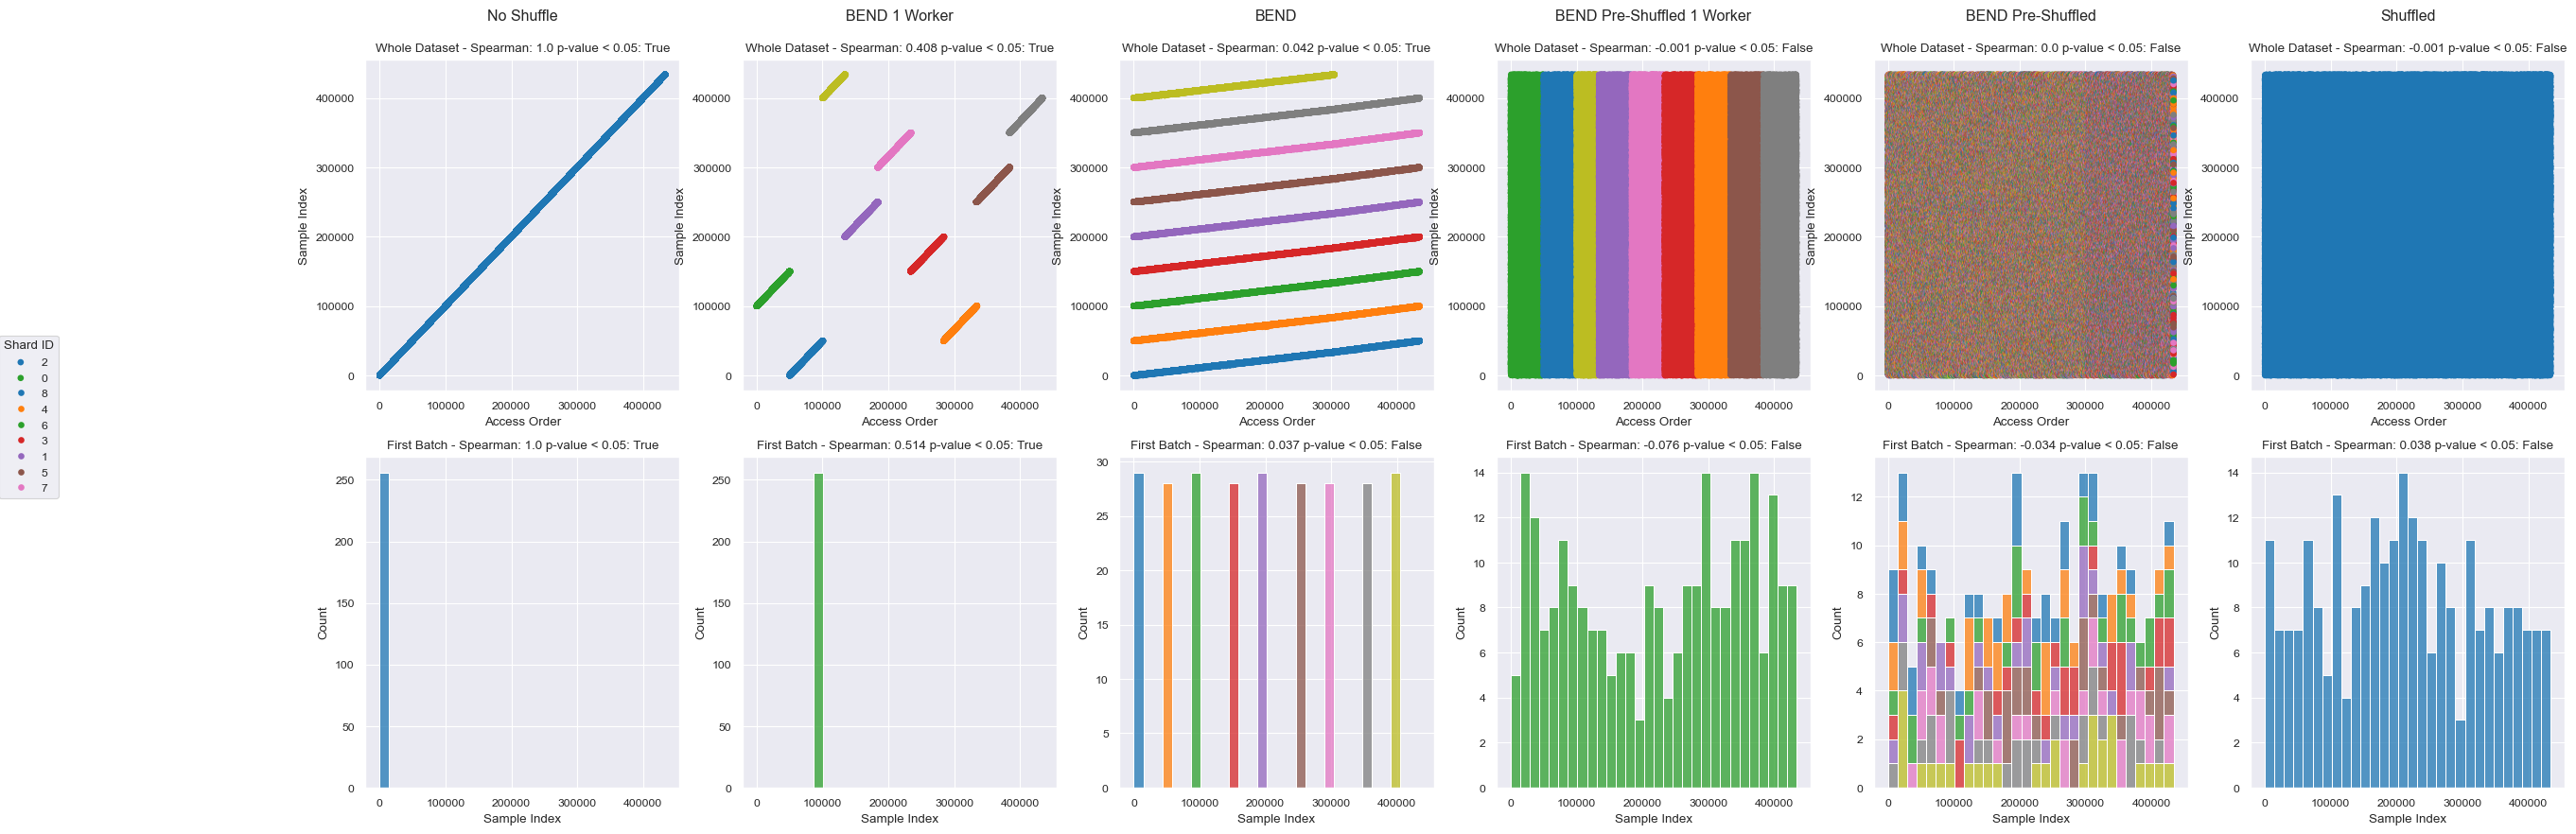

In [96]:
ncols = len(df_all['Name'].unique())
nrows = 2
bins = 30

fig, ax = plt.subplots(figsize=(5*ncols, 5*nrows), ncols=ncols, nrows=nrows, sharex=False, sharey=False)
plots = []
for idx, name in enumerate(df_all['Name'].unique()):
    df_name = df_all[df_all['Name'] == name]

    hue = df_name['shard_idx'] if not df_name['shard_idx'].isna().all() else None
    palette = None
    if hue is not None:
        shard_idx_unique = df_name['shard_idx'].unique()
        if len(shard_idx_unique) == 1:
            palette = [sns.color_palette("tab10")[shard_idx_unique[0]]]
        else:
            palette = 'tab10'

    plots.append(sns.scatterplot(x=df_name['access_order'], y=df_name['sample_idx'], edgecolor='none', hue=hue, palette=palette, ax=ax[0, idx]))

    corr, p_value = calculate_spearman(df_name['access_order'], df_name['sample_idx'])
    ax[0, idx].set_title(f"Whole Dataset - Spearman: {corr.round(3)} p-value < 0.05: {p_value < 0.05}")
    ax[0, idx].set_xlabel('Access Order')
    ax[0, idx].set_ylabel('Sample Index')
    
    sns.histplot(data=df_name[:BATCH_SIZE], x='sample_idx', hue=hue, multiple='stack', stat='count', bins=bins, binrange=(0, len(df_name)), palette=palette, ax=ax[1, idx])

    corr, p_value = calculate_spearman(df_name['access_order'][:BATCH_SIZE], df_name['sample_idx'][:BATCH_SIZE])
    ax[1, idx].set_title(f"First Batch - Spearman: {corr.round(3)} p-value < 0.05: {p_value < 0.05}")
    ax[1, idx].set_xlabel('Sample Index')
    ax[1, idx].set_ylabel('Count')
    
    if hue is not None:
        ax[0, idx].legend().set_visible(False)
        ax[1, idx].legend().set_visible(False)
        


for axis, col in zip(ax[0], df_all['Name'].unique()):

    axis.annotate(col, xy=(0.5, 1), xytext=(0, 30),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')


# Create the legend
lines_labels = df_bend['shard_idx'].unique()
# line_labels = [f'Shard {i}' for i in lines_labels]
fig.legend(plots,   
           labels=lines_labels,   
           loc="center left",   
           borderaxespad=-0.1,    # Small spacing around legend box
           title="Shard ID"
           )